In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

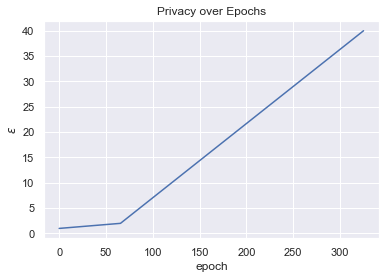

In [9]:
# Plot epsilon growth. Values copied and pasted from model_history.csv. 
sns.set()

x = [0.0287, 65.4878, 72.3163, 79.1449, 85.9735, 92.802, 99.6306, 106.4591, 113.2877, 120.1163, 126.9448, 133.7734, 140.6019, \
     147.4305, 154.2591, 161.0876, 167.9161, 174.7447, 181.5733, 188.4018, 195.2304, 202.0589, 208.8875, 215.7161, 222.5446, 229.3732, \
     236.2017, 243.0303, 249.8588, 256.6874, 263.516, 270.3445, 277.173, 284.0016, 290.8302, 297.6587, 304.4873, 311.3158, 318.1444, 324.973]

y = np.arange(1, 41)
plt.plot(x, y)
plt.xlabel('epoch')
plt.ylabel(r'$\epsilon$')
plt.title('Privacy over Epochs');

In [81]:
import pandas as pd

# Read in Netflix data
data_original = pd.read_csv("https://gretel-public-website.s3.amazonaws.com/datasets/netflix/netflix.txt", header = None)

In [70]:
num_samples = int(len(data_original) * .1)

In [71]:
print(num_samples)

2405376


In [72]:
# Sample from original data

data_original = data_original.sample(n=num_samples, random_state=1)

In [120]:
# Read in synthetic data

data_synthetic = pd.read_csv("https://raw.githubusercontent.com/bialasann/CS208_data/main/syn_data_netflix.txt", header = None)

In [121]:
data_original.columns = ['user id', 'movie id', 'rating', 'date']

In [122]:
data_synthetic.columns = ['user id', 'movie id', 'rating', 'date']

In [123]:
data_original.head()

,user id,movie id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [124]:
data_synthetic.head()

,user id,movie id,rating,date
0,88,121009,4,2005-07-05
1,2,2238537,4,2005-02-28
2,1058,1,4,2003-04-22
3,28,3187,3,2005-01-12
4,21,7236756,3,2005-02-05


In [244]:
# Some preliminary cleaning 

data_synthetic['rating'] = np.where(data_synthetic['rating'] > 5, 5, data_synthetic['rating'])
data_synthetic['rating'] = np.where(data_synthetic['rating'] < 1, 1, data_synthetic['rating'])
data_synthetic['movie id'] = np.where(data_synthetic['movie id'] < 0, 0, data_synthetic['movie id'])
data_synthetic['user id'] = np.where(data_synthetic['user id'] < 0, 0, data_synthetic['user id'])

### Queries

Here we compare various queries: average and median. We'll perform bootstrapping of the original dataset to get an estimate of the true population statistic. 

#### Count

In [288]:
# Compare average, median rating

means = []
medians = []

num_samples = 1000

for i in range(1000):
    
    bootstrap = np.random.choice(data_original.iloc[:, 2], num_samples, replace = True)
    mean = np.mean(bootstrap)
    means.append(mean)
    median = np.median(bootstrap)
    medians.append(median)
    
print('Population average rating:', np.mean(means))
print('Variance:', np.var(means))

print('Synthetic average rating:', np.mean(data_synthetic.iloc[:, 2]))
print()
print('Population median rating:', np.mean(medians))
print('Variance:', np.var(medians))
print('Synthetic median rating:', np.median(data_synthetic.iloc[:, 2]))

Population average rating: 3.6015
Variance: 0.0012730259999999992
Synthetic average rating: 3.503

Population median rating: 4.0
Variance: 0.0
Synthetic median rating: 4.0


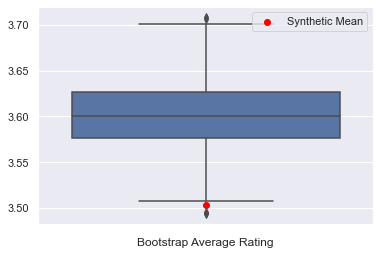

In [289]:
ax = sns.boxplot(data=np.array(means))
ax.set(xticklabels=[])
ax.scatter([0], [np.mean(data_synthetic.iloc[:, 2])], color = 'red', label = 'Synthetic Mean')
plt.legend()
ax.set_xlabel('Bootstrap Average Rating');

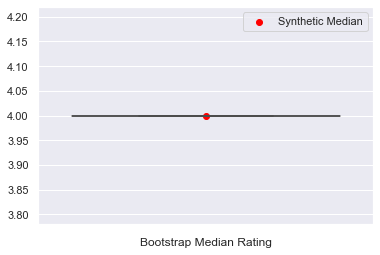

In [290]:
ax = sns.boxplot(data=np.array(medians))
ax.set(xticklabels=[])
ax.scatter([0], [np.median(data_synthetic.iloc[:, 2])], color = 'red', label = 'Synthetic Median')
plt.legend();
ax.set_xlabel('Bootstrap Median Rating');

### Total Variation Distance

We're measuring total variation distance of **rating** because our variable is categorical. 

In [293]:
tvds = []
num_samples = 1000

for i in range(1000):
    
    bootstrap = np.random.choice(data_original.iloc[:, 2], num_samples, replace = True)
    tvd = 0.5*sum(abs(np.array(bootstrap) - np.array(data_synthetic.iloc[:, 2])))
    tvds.append(tvd)

In [294]:
print('Average total variation distance: ', np.mean(tvd))

Average total variation distance:  615.5


### Covariance of Variables

We'll check that the correlation between **movie id** and **rating** is still statistically significant. Our null hypothesis (H0) is that the two variables are independent. 

In [281]:
from scipy.stats import chi2_contingency

In [282]:
stat, p, dof, expected = chi2_contingency(data_original.iloc[:, [1, 2]])
  
# interpret p-value

alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


In [283]:
stat, p, dof, expected

(613728796.3308458,
 0.0,
 24053763,
 array([[1.48884295e+06, 4.05305116e+00],
        [8.22111762e+05, 2.23802050e+00],
        [8.85014591e+05, 2.40925977e+00],
        ...,
        [5.12539605e+05, 1.39527762e+00],
        [9.88963308e+05, 2.69223755e+00],
        [1.70441436e+06, 4.63989746e+00]]))

In [284]:
stat, p, dof, expected = chi2_contingency(data_synthetic.iloc[:, [1, 2]])
  
# interpret p-value

alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


In [285]:
stat, p, dof, expected

(24261491197.019638,
 0.0,
 999,
 array([[1.21013000e+05, 6.74093379e-05],
        [2.23854100e+06, 1.24696162e-03],
        [5.00000000e+00, 2.78521059e-09],
        ...,
        [2.21554190e+07, 1.23415015e-02],
        [9.18235099e+06, 5.11495626e-03],
        [9.31229999e+05, 5.18734332e-04]]))

### Point Estimates

What's the probability of receiving a certain review? Here, we compare point estimates of the two distributions. 

In [286]:
# Probability of receiving each rating 

prob_arr = []

num_samples = 1000

for i in range(1000):
    
    bootstrap = np.random.choice(data_original.iloc[:, 2], num_samples, replace = True)
    unique, counts = np.unique(bootstrap, return_counts=True)
    prob_arr.append(counts/num_samples)

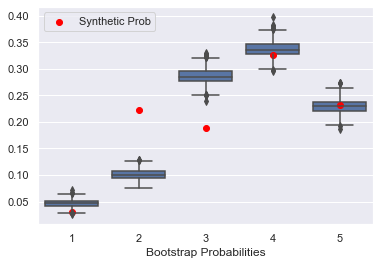

In [287]:
ax = sns.boxplot(data=np.array(prob_arr), color = 'b')
ax.set(xticklabels=[1, 2, 3, 4, 5])
unique, synt_counts = np.unique(data_synthetic.iloc[:, 2], return_counts=True)
ax.scatter([0, 1, 2, 3, 4], synt_counts/len(data_synthetic), color = 'red', label = 'Synthetic Prob')
plt.legend();
ax.set_xlabel('Bootstrap Probabilities');